## Compare SVC in the case of binary class (Sell, Buy)

In [13]:
import sys
from pathlib import Path

import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_svc,
    plot_feature_imp,
    plot_strategy,
)

In [14]:
metric = "precision"
test_size = 300

In [15]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [16]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [17]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [18]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [19]:
interest_rate = wk_df["r"].values

In [20]:
def select_threshold(proba, target, fpr_max=0.1):
    # calculate roc curves
    fpr, _, thresholds = roc_curve(target, proba)
    # get the best threshold with fpr <=0.1
    best_threshold = thresholds[fpr <= fpr_max][-1]

    return best_threshold

## Baseline SVC Classifier without new data + r

In [21]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [22]:
orig_df["r"] = interest_rate

### Split dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 21:50:31,892] A new study created in memory with name: no-name-a9b73534-3886-4ae2-a0ab-e375e3c00945
[I 2024-02-13 21:50:32,264] Trial 0 finished with value: 0.5454248725144133 and parameters: {'kernel': 'poly', 'degree': 3, 'C': 1.6057240835298185, 'gamma': 'scale', 'shrinking': False}. Best is trial 0 with value: 0.5454248725144133.
[I 2024-02-13 21:50:32,941] Trial 1 finished with value: 0.5493410079817529 and parameters: {'kernel': 'poly', 'degree': 3, 'C': 4.734537197485747, 'gamma': 'scale', 'shrinking': False}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:33,258] Trial 2 finished with value: 0.5030025715313424 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'C': 0.9024453585695684, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:33,527] Trial 3 finished with value: 0.4989022511722423 and parameters: {'kernel': 'sigmoid', 'degree': 7, 'C': 7.672317414348969, 'gamma': 'scale', 'shrinki

[I 2024-02-13 21:50:34,021] Trial 4 finished with value: 0.5053033263801152 and parameters: {'kernel': 'sigmoid', 'degree': 8, 'C': 1.8310483414941598, 'gamma': 'scale', 'shrinking': False}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:34,253] Trial 5 finished with value: 0.4996010580075806 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'C': 3.0875987789503387, 'gamma': 'scale', 'shrinking': True}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:34,476] Trial 6 finished with value: 0.5301875738586637 and parameters: {'kernel': 'linear', 'degree': 2, 'C': 0.02562002885672556, 'gamma': 'auto', 'shrinking': True}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:34,865] Trial 7 finished with value: 0.5304401900587444 and parameters: {'kernel': 'linear', 'degree': 6, 'C': 0.020112260053045738, 'gamma': 'auto', 'shrinking': True}. Best is trial 1 with value: 0.5493410079817529.
[I 2024-02-13 21:50:37,398] Trial 8 finished wit

Number of finished trials: 150
Best trial:
  Value: 0.5983115072921132
  Params: 
    kernel: rbf
    degree: 6
    C: 97.17027204130156
    gamma: scale
    shrinking: True


In [30]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**trial.params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [31]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=97.17027204130156, degree=6, probability=True,
                     random_state=1968))])

In [32]:
# In-sample score
pipe.score(X_train, y_train)

0.7335069444444444

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       576
           1       0.72      0.78      0.74       576

    accuracy                           0.73      1152
   macro avg       0.74      0.73      0.73      1152
weighted avg       0.74      0.73      0.73      1152



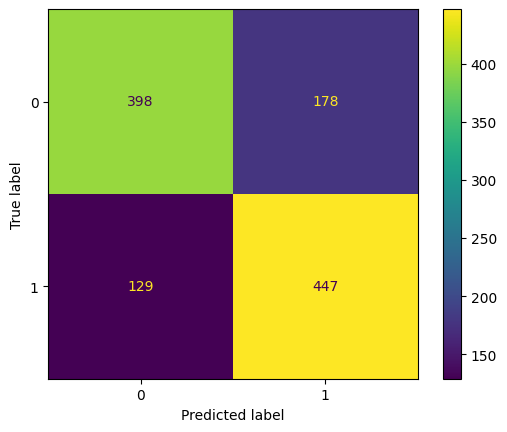

In [33]:
display_report(y_train, pipe.predict(X_train))

In [34]:
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.15)

In [35]:
predictions = pipe.predict(X_test)

In [36]:
pipe.score(X_test, y_test)

0.52

              precision    recall  f1-score   support

           0       0.56      0.75      0.64       170
           1       0.40      0.22      0.29       130

    accuracy                           0.52       300
   macro avg       0.48      0.49      0.46       300
weighted avg       0.49      0.52      0.49       300



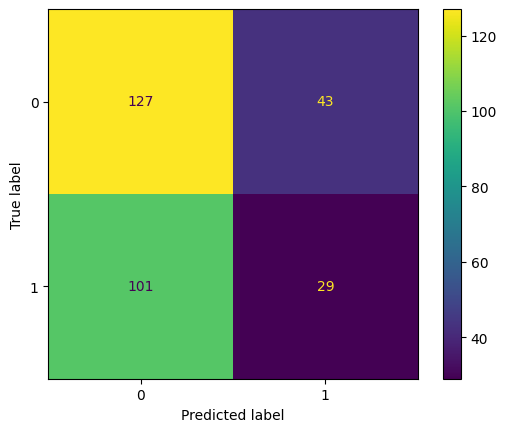

In [37]:
display_report(y_test, predictions)

In [39]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

In [41]:
new_preds = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

              precision    recall  f1-score   support

           0       0.56      0.79      0.66       170
           1       0.40      0.18      0.24       130

    accuracy                           0.53       300
   macro avg       0.48      0.49      0.45       300
weighted avg       0.49      0.53      0.48       300



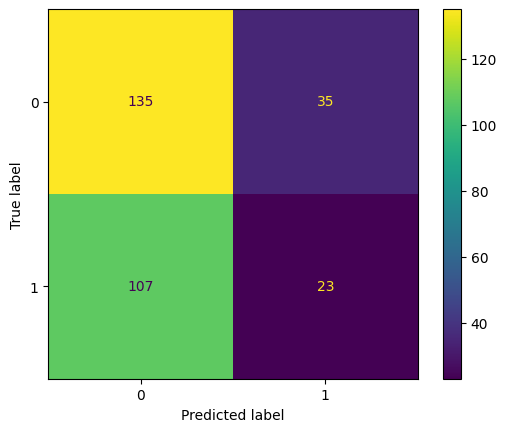

In [42]:
display_report(y_test, new_preds)

In [43]:
strategy_df = backtest_strategy(new_preds, X_test, spy, ml_df)

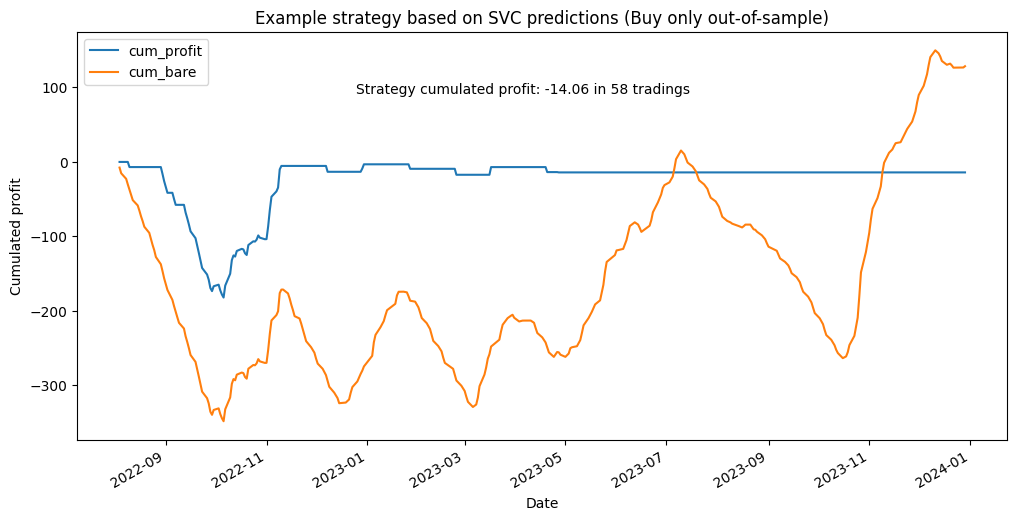

In [44]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

### Backtesting

In [45]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [46]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.0,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.0,-7.660000,0.000000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.0,-7.440000,0.000000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.0,-7.510000,0.000000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.9,-6.900000,-6.900000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,11.920012,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,11.920012,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,11.920012,126.819912


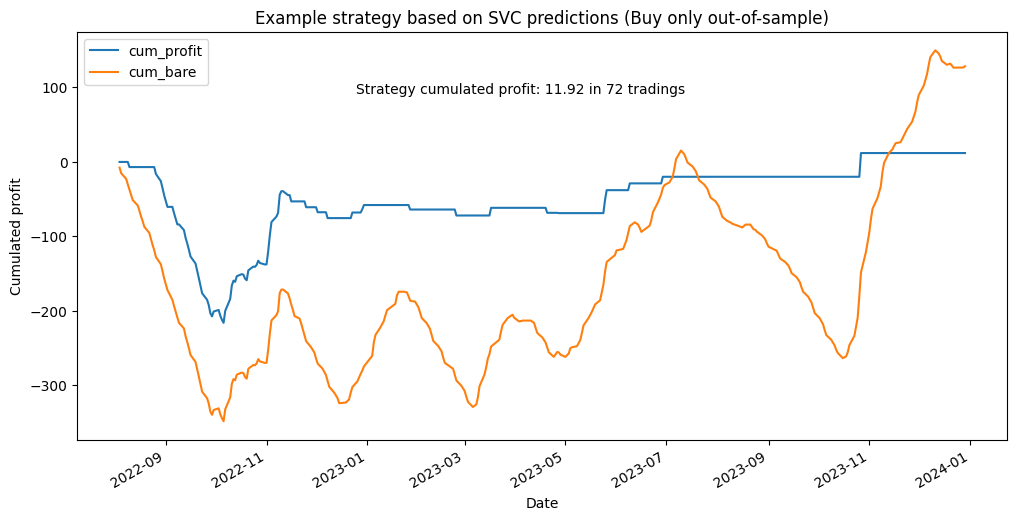

In [47]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

## SVC with data from MC simulation and additional features

In [48]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [49]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [51]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 21:57:43,809] A new study created in memory with name: no-name-2fbc4882-f653-4e57-8ae0-fee1cac15187


[I 2024-02-13 21:57:44,433] Trial 0 finished with value: 0.6151847664510186 and parameters: {'kernel': 'rbf', 'degree': 3, 'C': 13.055951897250223, 'gamma': 'auto', 'shrinking': True}. Best is trial 0 with value: 0.6151847664510186.
[I 2024-02-13 21:57:44,824] Trial 1 finished with value: 0.5379666675193778 and parameters: {'kernel': 'linear', 'degree': 6, 'C': 1.4267333269021474, 'gamma': 'auto', 'shrinking': True}. Best is trial 0 with value: 0.6151847664510186.
[I 2024-02-13 21:57:45,080] Trial 2 finished with value: 0.5223666555117752 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 0.024211772268296808, 'gamma': 'scale', 'shrinking': False}. Best is trial 0 with value: 0.6151847664510186.
[I 2024-02-13 21:57:45,523] Trial 3 finished with value: 0.531909123438753 and parameters: {'kernel': 'poly', 'degree': 7, 'C': 0.06479723836982194, 'gamma': 'auto', 'shrinking': True}. Best is trial 0 with value: 0.6151847664510186.
[I 2024-02-13 21:57:45,842] Trial 4 finished with value: 0.

Number of finished trials: 150
Best trial:
  Value: 0.6442823913131884
  Params: 
    kernel: rbf
    degree: 5
    C: 80.099708129385
    gamma: auto
    shrinking: False


In [52]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**study.best_params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [53]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=80.099708129385, degree=5, gamma='auto',
                     probability=True, random_state=1968, shrinking=False))])

In [54]:
# In-sample score
pipe.score(X_train, y_train)

0.8046875

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       576
           1       0.80      0.82      0.81       576

    accuracy                           0.80      1152
   macro avg       0.80      0.80      0.80      1152
weighted avg       0.80      0.80      0.80      1152



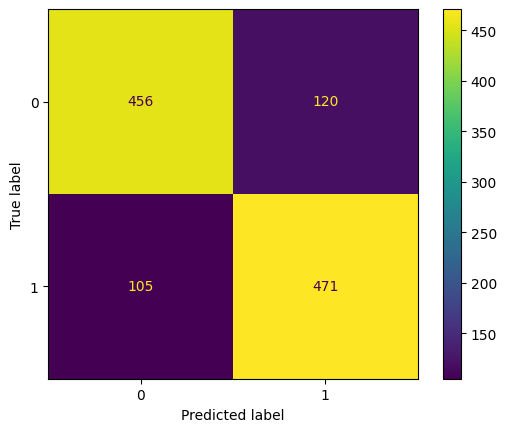

In [56]:
display_report(y_train, pipe.predict(X_train))

In [69]:
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(threshold)

0.6246718706396471


In [67]:
new_preds = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

              precision    recall  f1-score   support

           0       0.77      0.24      0.36       170
           1       0.48      0.91      0.62       130

    accuracy                           0.53       300
   macro avg       0.62      0.57      0.49       300
weighted avg       0.64      0.53      0.47       300



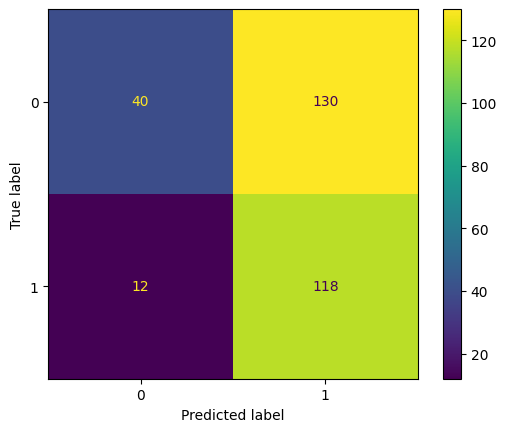

In [68]:
display_report(y_test, new_preds)

In [70]:
strategy_df = backtest_strategy(new_preds, X_test, spy, ml_df)

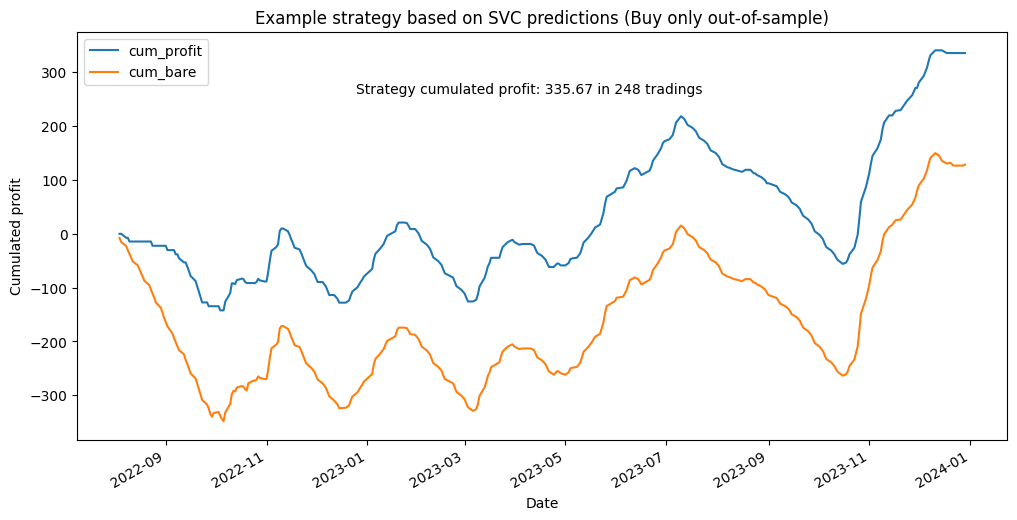

In [71]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

In [72]:
predictions = pipe.predict(X_test)

In [73]:
pipe.score(X_test, y_test)

0.49666666666666665

              precision    recall  f1-score   support

           0       0.95      0.12      0.21       170
           1       0.46      0.99      0.63       130

    accuracy                           0.50       300
   macro avg       0.71      0.55      0.42       300
weighted avg       0.74      0.50      0.39       300



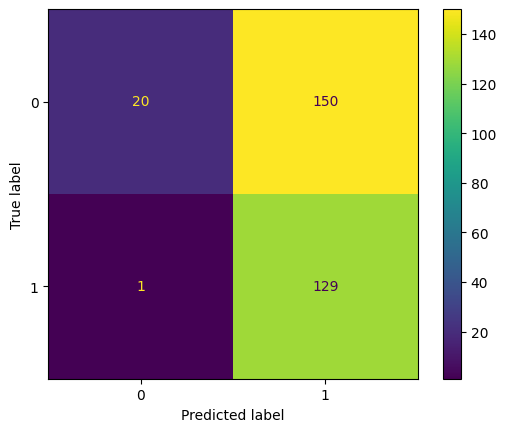

In [74]:
display_report(y_test, predictions)

In [75]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [76]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [77]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.000000,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.000000,-7.660000,0.000000,-15.240000
2022-08-08,1,413.0,7.44,2022-08-29,402.630005,-7.440000,-7.440000,-7.440000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.000000,-7.510000,-7.440000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.900000,-6.900000,-14.340000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,283.889938,129.599927
2023-12-22,1,474.0,5.70,2024-01-12,476.679993,-3.020007,-3.020007,280.869930,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,280.869930,126.819912


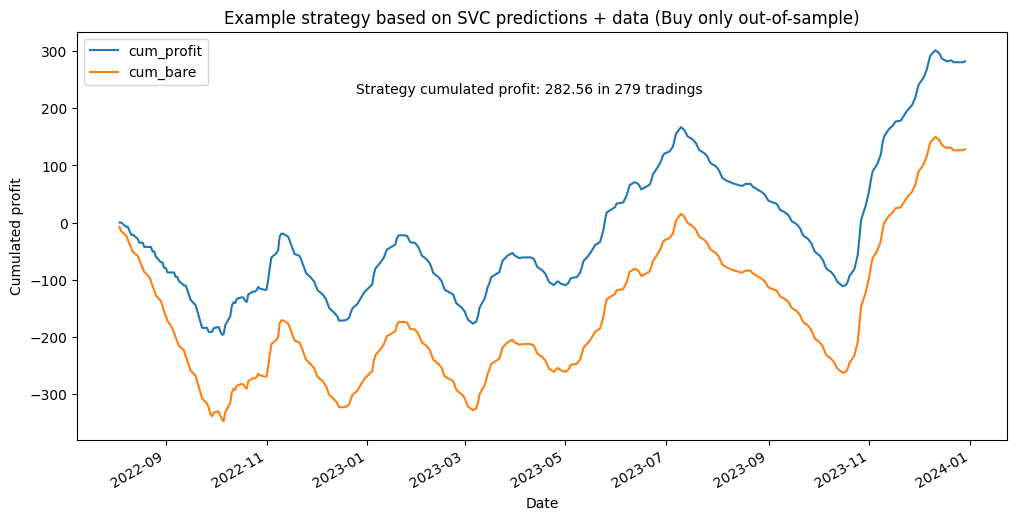

In [78]:
plot_strategy(strategy_df, "SVC", "+ data (Buy only out-of-sample)")

## Compare the two predictions

In [79]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [80]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,mmar_rf_pred_out
2,0,1
5,0,1
7,0,1
8,0,1
11,0,1
...,...,...
293,0,1
294,0,1
296,0,1
298,0,1


In [ ]:
compare_df[mask_out].shape

(60, 2)

In [ ]:
compare_df.sum(axis=0)

bare_rf_pred_out    34
mmar_rf_pred_out    86
dtype: int64